# Using GAN for Generating Hand-written Digit Images

**GAN (Generative Adversarial Network)** [[1]](#ref1) is a framework proposed by Ian Goodfellow, Yoshua Bengio and others in 2014.  

A GAN can be trained to generate images from random noises.  For example, we can train a GAN on MNIST (hand-written digits dataset) to generate digit images that look like hand-written digit images from MNIST, which could be used to train other neural networks.

The code in this notebook is based on the **GAN MNIST example in TensorFlow by Udacity** [[2]](#ref2) which uses TensorFlow, but we use Keras on top of TensorFlow for more straightforward construction of networks.  Many of the ideas on training are from **How to Train a GAN? Tips and tricks to make GANs work** [[4]](#ref4).

## MNIST

MNIST is a well known database of handwritten digits [[3]](#ref3).

In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

The below will download MNIST dataset (if not already).

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Let's examine sample images.  We use 'gray' color map since it has no color information.

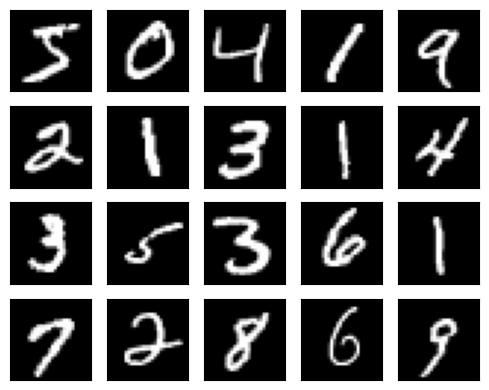

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

All MNIST digit images come in 28x28 size.

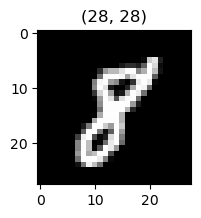

In [4]:
sample = X_train[17]

plt.figure(figsize=(3, 2))
plt.title(sample.shape)
plt.imshow(sample, cmap='gray')
plt.show()

The minimum and maximum sizes of MNIST image data is 0 and 255 respectively.

In [5]:
X_train.min(), X_train.max()

(0, 255)

## Generator

We want to build a generator that generates realistic hand-written images.  

<img src='../images/gan_mnist/generator_good.png' width='65%'/>

The input to the generator is called 'latent sample' which is a series of randomly generated numbers.  We use the normal distribution rather than the uniform distribution as suggested in [[4]](#ref4).

In [6]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The sample size is a hyperparameter.  Below, we use a vector of 100 randomly generated number as a sample.

In [7]:
make_latent_samples(1, 100) # generates one sample

array([[-0.94328408,  0.10341654, -0.64234167, -0.28717341,  0.05734988,
        -0.70048694, -0.91652049,  0.3509213 ,  0.18510685,  0.30225641,
         0.41360019, -0.46828807, -0.23557625, -0.30822576,  1.51867919,
        -1.29348116, -0.10165513, -0.06296953,  0.09631239,  0.70697053,
         1.38934022, -0.29683832,  0.01174663,  0.87568985, -0.83318709,
         0.9741629 , -0.15138761, -0.03303656,  0.97611088,  1.10954016,
         2.09584535,  1.10156142,  0.50475767,  0.19929358,  0.24255244,
         0.03161201, -2.04009106,  0.26776347, -0.55393997, -0.38305183,
         1.41860781, -1.7755733 , -1.50690581,  0.01163966,  2.45216288,
         1.48693344, -1.12078185, -1.23329095,  1.51623521, -0.76080275,
         1.3727295 ,  1.2483706 , -1.93458541,  0.84565831, -0.53429517,
        -1.09288435, -0.01094312, -2.33866056, -0.37568748, -1.41122712,
        -0.46555088, -0.46626474, -1.7031357 , -1.99818596,  0.1465457 ,
         0.21669947,  0.50542307,  0.4817635 , -0.7

The generator is a simple fully connected neural network with one hidden layer with the leaky ReLU activation.  It takes one latent sample (100 values) and produces 784 (=28x28) data points which represent a digit image.

In [8]:
generator = Sequential([
    Dense(128, input_shape=(100,)),
    LeakyReLU(alpha=0.01),
    Dense(784),
    Activation('tanh')
], name='generator')

generator.summary()

/Users/umair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/umair/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 784)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,064 (445.56 KB)

 Trainable params: 114,064 (445.56 KB)

 Non-trainable params: 0 (0.00 B)

The last activation is **tanh**.  According to [[4]](#ref4), this works the best.  It also means that we need to rescale the MNIST images to be between -1 and 1.

Initially, the generator can only produce garbages.

<img src='../images/gan_mnist/generator_bad.png' width='65%'/>

As such, the generator needs to learn how to generate realistic hand-written images from the latent sample (randomly generated numbers).

How to train this generator?  That is the question tackled by GAN.

Before talking about GAN, we shall discuss the discriminator.

## Discriminator

The discriminator takes a digit image and classifies whether an image is real (1) or not (0).  

If the input image is from the MNIST database, the discriminator should classify it as real.

<img src='../images/gan_mnist/discriminator_real.png' width='50%'/>

If the input image is from the generator, the discriminator should classify it as fake.

<img src='../images/gan_mnist/discriminator_fake.png' width='50%'/>

The discriminator is a simple fully connected neural network with one hidden layer with the leaky ReLU activation.

In [9]:
discriminator = Sequential([
    Dense(128, input_shape=(784,)),
    LeakyReLU(alpha=0.01),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

The last activation is **sigmoid** to tell us the probability of whether the input image is real or not.

We train the discriminator using both the MNIST images and the images generated by the generator.

## GAN

We connect the generator and the discriminator to produce a GAN.  

It takes the latent sample, and the generator inside GAN produces a digit image which the discriminator inside GAN classifies as real or fake.

<img src='../images/gan_mnist/gan.png' width='70%'/>

If the generated digit image is so realistic, the discriminator in the GAN classifies it as real, which is what we want to achieve.

We set the discriminator inside the GAN not-trainable, so it is merely evaluating the quality of the generated image.  The label is always 1 (real) so that if the generator fails to produce a realistic digit image, its cost becomes high, and when the back-propagation occurs in GAN, the weights in the generator network gets updated.

In [10]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator (Sequential)          │ (None, 784)            │       114,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Sequential)      │ (None, 1)              │       100,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,673 (838.57 KB)

 Trainable params: 214,673 (838.57 KB)

 Non-trainable params: 0 (0.00 B)

As you can see, the GAN internally uses the same generator and the discriminator models.  The GAN maintains the same shared weights with the generator and the disriminator.  Therefore, training the GAN also trains the generator.  However, we do not want the discriminator to be affected while training the GAN.

<img src='../images/gan_mnist/generator_discriminator.png' width='90%'/>

We train the discriminator and the GAN in turn and repeat the training many times until both are trained well.  

<img src='../images/gan_mnist/gan_overview.png' width='90%'/>

While training the GAN, the back-propagation should update the weights of the generator but not the discriminator.

As such, we need a way to make the discriminator trainable and non-trainable.

In [11]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [12]:
make_trainable(discriminator, False)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 100,609 (393.00 KB)

In [13]:
make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

The below function combines everything we have discussed so far to build the generator, discriminator, and GAN models and also compile them for training.

In [14]:
def make_simple_GAN(sample_size, 
                    g_hidden_size, 
                    d_hidden_size, 
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(784),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(784,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(learning_rate=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(learning_rate=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

## Training GAN

### Preprocessing

We need to flatten the digit image data as the fully connected input layer expects that.  Also, as the generator uses the **tanh** activation in the output layer, we scale all the MNIST images to have values between -1 and 1.

In [15]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [16]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

### Deprocessing

We also need a function to reverse the preprocessing so that we can display generated images.

In [17]:
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

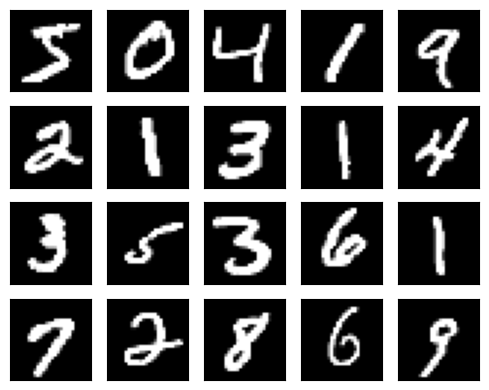

In [18]:
plt.figure(figsize=(5, 4))
for i in range(20):
    img = deprocess(X_train_real[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### Labels

The labels are 1 (real) or 0 (fake) in 2D shape.

In [19]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

The below is 10 sets of real and fake label values.

In [20]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

Later, we prepare the labels for training and evaluation using the train batch size and the test size.  

### Label Smoothing

One last point before we start training is the label smoothing which makes the discriminator generalize better [[4]](#ref4).

For the real digit images, the labels are all 1s.  However, when we train the discriminator, we use a value slightly smaller than 1 with the real digit images.  Otherwise, the discriminator might overfit to the training data and rejects anything else that is slightly different from the training images.

### Training Loop

We repeat the following to make both the discriminator and the generator better and better:

* Prepare a batch of real images
* Prepare a batch of fake images generated by the generator using latent samples
* Make the discriminator trainable
* Train the discriminator to classify the real and fake images
* Make the discriminator non-trainable
* Train the generator via the GAN

When training the generator via the GAN, the expect labels are all 1s (real).  Initially, the generator produces not very realistic images so the discriminator classifies them as 0s (fake), which causes the back-propagation to adjust the weights inside the generator.  The discriminator is not affected as we set it non-trainable in this step.

In [ ]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))    

### Stabilizing GAN

As it turns out, training a GAN is quite hard, and there are many tricks and heuristics required [[4]](#ref4).  It is because the discriminator and the generator are not cooperating and individually learning to predict better.  

For example, the generator might learn to fool the discriminator with garbage.   Ideally, the discriminator should learn earlier than the generator so that it can classify images accurately.

Therefore, I used different learning rates for the generator and the discriminator.  I wanted to slow down the generator learning so that the discriminator learns to classify well.

I am not 100% certain if this is a generally good strategy to use but it does seem to work in this project.

As the generator learns more and the loss decreases, the discriminator's loss increases.  I see kind of equilibrium around 80-90 epochs.

In [ ]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

### Tracking Failures

According to [[4]](#ref4), 

* The discriminator loss = 0 means something is wrong
* When things are working, the discriminator loss has low variance and goes down over time.
* When things are not working, the discriminator loss has huge variance and spiking
* If the generator loss steadily decreases, it is fooling the discriminator with garbage.


### Don't balance via loss statistics 

According to [[4]](#ref4), 

* i.e., don't try to find a (number of G/number of D) schedule to uncollapse training

## Testing the Generator

Now we generates some digit images using the trained generator.

In [ ]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

The results are not outstanding as we are using simple networks.  Deep Convolutional GAN (aka DCGAN) would produce better results than this.

## References

<a id="ref1"></a>
### [1] Generative Adversarial Networks
 
Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio
  
https://arxiv.org/abs/1406.2661
 
<a id="ref2"></a> 
### [2] GAN MNIST Example in TensorFlow
 
Udacity
 
https://github.com/udacity/deep-learning/tree/master/gan_mnist

<a id="ref3"></a>
### [3] MNIST dataset
 
Yann LeCun
 
http://yann.lecun.com/exdb/mnist/

<a id="ref4"></a>
### [4] How to Train a GAN? Tips and tricks to make GANs work

Facebook AI Research: Soumith Chintala, Emily Denton, Martin Arjovsky, Michael Mathieu

https://github.com/soumith/ganhacks

https://www.youtube.com/watch?v=X1mUN6dD8uE
